# Occupancy Detector - Multivariate Time Series Analysis

This notebook will analyze the [occupancy detection dataset](https://archive.ics.uci.edu/dataset/357/occupancy+detection), which provides multivariate timeseries information that can be used to predict whether or not the room is occupied at the time.

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import pathlib
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Environment
Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-05 19:55:18.410119


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers
Defining helper functions to make split certain functionality out of tasks.

In [9]:
def download_and_format_data(file: pathlib.Path) -> pd.DataFrame:
    """ Helper function to download the datset from a file, then properly format it
        into a nice dataframe.

        Args:
            file (pathlib.Path): the path to the txt file to download.

        Returns
            (pd.DataFrame) the structured dataframe.
    """
    data = data_toolbox.read_txt_file_from_directory(str(file))

    # Extracting column names
    columns = data[0].replace('"', '').split(',')
    columns.insert(0, 'id')

    cleaned_data = []
    for row in data[1:]:
        if len(row) == 0:
            continue

        split_data = row.replace('"', '').split(',')
        cleaned_data.append({
            columns[0]: int(split_data[0]),
            columns[1]: split_data[1],
            columns[2]: float(split_data[2]),
            columns[3]: float(split_data[3]),
            columns[4]: float(split_data[4]),
            columns[5]: float(split_data[5]),
            columns[6]: float(split_data[6]),
            columns[7]: int(split_data[7]),
        })

    return pd.DataFrame(cleaned_data)

In [10]:
def plot_multivariate_data(data_df: pd.DataFrame) -> None:
    """ Plots the various features against time steps across 5 graphs.

        Args:
            data_df (pd.DataFrame): the dataframe generated from output of `download_and_format_data` to plot
    """
    fig, axs = plt.subplots(6, figsize=(12, 8), sharex=True)

    fig.suptitle('Multivariate Data')
    x = data_df['id']

    features_df = data_df.drop('id', axis=1).drop('date', axis=1)

    for index, feature in enumerate(features_df):
        axs[index].plot(x, data_df[feature])
        axs[index].set_title(feature.capitalize())

    fig.tight_layout()

In [11]:
def make_windowed_dataset(series: np.ndarray,
                          window_size: int = 7,
                          batch_size: int = 32, 
                          include_occupancy: bool = True) -> tf.data.Dataset:
    """ Creates a windowed dataset from the given series.

        Args:
            series (ArrayLike): the series to create the windowed dataset from.
            window_size (int): the size of the window.
            batch_size (int): the size of the batch.
        
        Returns:
            (tf.data.Dataset) the windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Only trying to predict a single binary value on outcome (occupied or not occupied)
    if include_occupancy:
        dataset = dataset.map(lambda window: (window[:-1, :], window[-1][-1]))
    else:
        dataset = dataset.map(lambda window: (window[:-1, :-1], window[-1][-1]))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [12]:
def make_predictions(model: tf.keras.models.Model, dataset: tf.data.Dataset) -> np.ndarray:
    """ Makes the predictions for the corresponding model and outputs the predicted classes.

        Args:
            model (tf.keras.models.Model): the model to make predictions with.
            dataset (tf.data.Dataset): the dataset to make predictions on.

        Returns:
            (np.ndarray) the predicted classes
    """
    pred_probs = model.predict(dataset)

    return tf.squeeze(tf.cast(tf.round(pred_probs), dtype=tf.int32))

In [13]:
def plot_occupancy_pred_vs_true(y_pred: tf.Tensor,
                                data_df: pd.DataFrame,
                                start: int,
                                end: int,
                                test_name: str):
    """ Plots the occupancy predictions vs the actual occpancy.

        Args:
            y_pred (tf.Tensor) the models predicted class (1, 0) of whether the room is occupied.
            data_df (pd.DataFrame) the dataframe that relates to the same data the preds were made on.
            start (int) where to start the graph at  (zooms in graph).
            end (int) where to end the graph at (zooms in graph).
            test_name (str) the title for the predicted data
    """
    # Data Visualization
    plt.figure(figsize=(12,4))
    ml_toolbox.analysis.timeseries.plot_price_vs_timesteps(data_df['id'],
                                                           data_df['Occupancy'],
                                                           format='-',
                                                           start=start,
                                                           end=end,
                                                           label='Test Data',
                                                           new_figure=False)

    ml_toolbox.analysis.timeseries.plot_price_vs_timesteps(data_df['id'].to_numpy()[1:],
                                                           y_pred,
                                                           format='-',
                                                           start=start,
                                                           end=end,
                                                           label=test_name,
                                                           new_figure=False)

In [14]:
def get_ensemble_models(input_shape: typing.Tuple,
                        train_data: tf.data.Dataset,
                        test_data: tf.data.Dataset,
                        num_iter: int = 10,
                        num_epochs: int = 100,
                        hidden_layer_sizes: typing.Optional[typing.List[int]] = None) -> typing.List[tf.keras.models.Sequential]:
    """ Returns a list of num_iter models each trained on loss function metrics.

        Example:
            num_iter=10 and loss_fn=['mae', 'mse', 'mape'],  a list of 30 trained models
            will be returned: 10 * len(['mae', 'mse', 'mape'])

        Args:
            input_shape (typing.Tuple): the input shape.
            train_data (tf.data.Dataset): the dataset to train the models on.
            test_data (tf.data.Dataset): the dataset to test/validate the models on.
            num_iter (int): the number of models for each loss function metric.
            num_epochs (int): the number of epochs to train the model on.
            hidden_layer_sizes (typing.Optional[typing.List[int]): the corresponding hidden layer
                sizes for dense layers.

        Returns:
            (List[Model]) the list of trained models.
    """
    hidden_layer_sizes = hidden_layer_sizes or [128, 128]

    ensemble_models = []

    for i in range(num_iter):
        print(f'Optimizing model by reducing: for {num_epochs}, model number: {i}')

        inputs = tf.keras.layers.Input(shape=input_shape)

        x = inputs
        for hidde_layer_size in hidden_layer_sizes:
            x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)

        x = tf.keras.layers.Flatten()(x)

        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs, outputs, name=f'ensemble_model_{i}')

        # Compile Model
        model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.legacy.Adam(),
                      metrics=['accuracy'])

        # Fit Model
        model.fit(train_data,
                  epochs=num_epochs,
                  verbose=0,
                  validation_data=test_data)

        ensemble_models.append(model)

    return ensemble_models

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file that was downloaded to the data directory, directly from the website.
* [occupancy detection dataset](https://archive.ics.uci.edu/dataset/357/occupancy+detection)

### Download & Format Data

In [15]:
DATA_DIR = pathlib.Path('./data/')

TEST_DATA_FILE = DATA_DIR / 'datatest2.txt'
TRAIN_DATA_FILE = DATA_DIR / 'datatraining.txt'

#### Viewing Data

Going to look at how the data comes in before I structure it to ensure I know how I 

In [16]:
raw_data = data_toolbox.read_txt_file_from_directory(str(TRAIN_DATA_FILE))

In [17]:
raw_data[:3]

['"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"',
 '"1","2015-02-04 17:51:00",23.18,27.272,426,721.25,0.00479298817650529,1',
 '"2","2015-02-04 17:51:59",23.15,27.2675,429.5,714,0.00478344094931065,1']

#### Download Data

After viewing the data from the raw file, I used the helper function, `download_and_format_data`, to generate structured dataframes of the downloaded data.

In [18]:
train_data_df = download_and_format_data(TRAIN_DATA_FILE)
test_data_df = download_and_format_data(TEST_DATA_FILE)

train_data_df.head()

,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### Analyzing Data

In [19]:
train_data_df

,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
1,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
2,3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
3,4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
4,5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...,...
8138,8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8139,8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8140,8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8141,8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [20]:
train_data_df['Occupancy'].value_counts()

Occupancy
0    6414
1    1729
Name: count, dtype: int64

In [21]:
test_data_df['Occupancy'].value_counts()

Occupancy
0    7703
1    2049
Name: count, dtype: int64

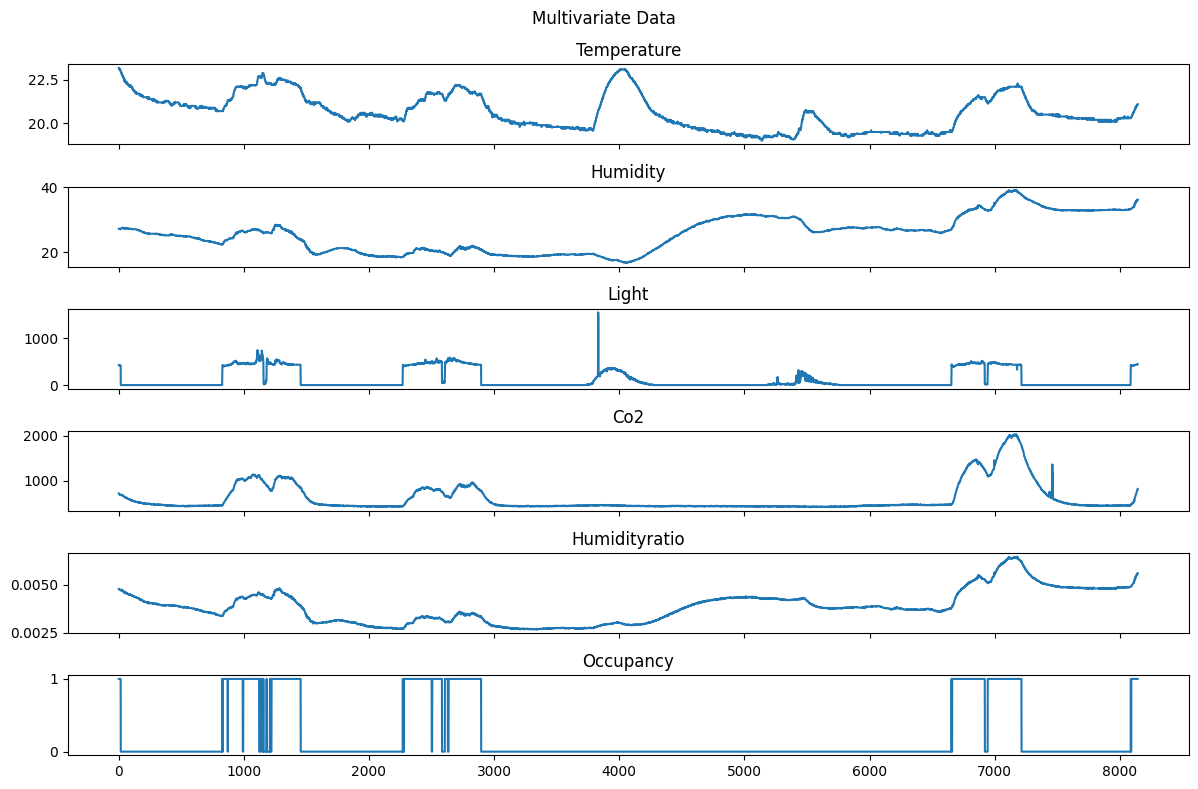

In [22]:
plot_multivariate_data(train_data_df)

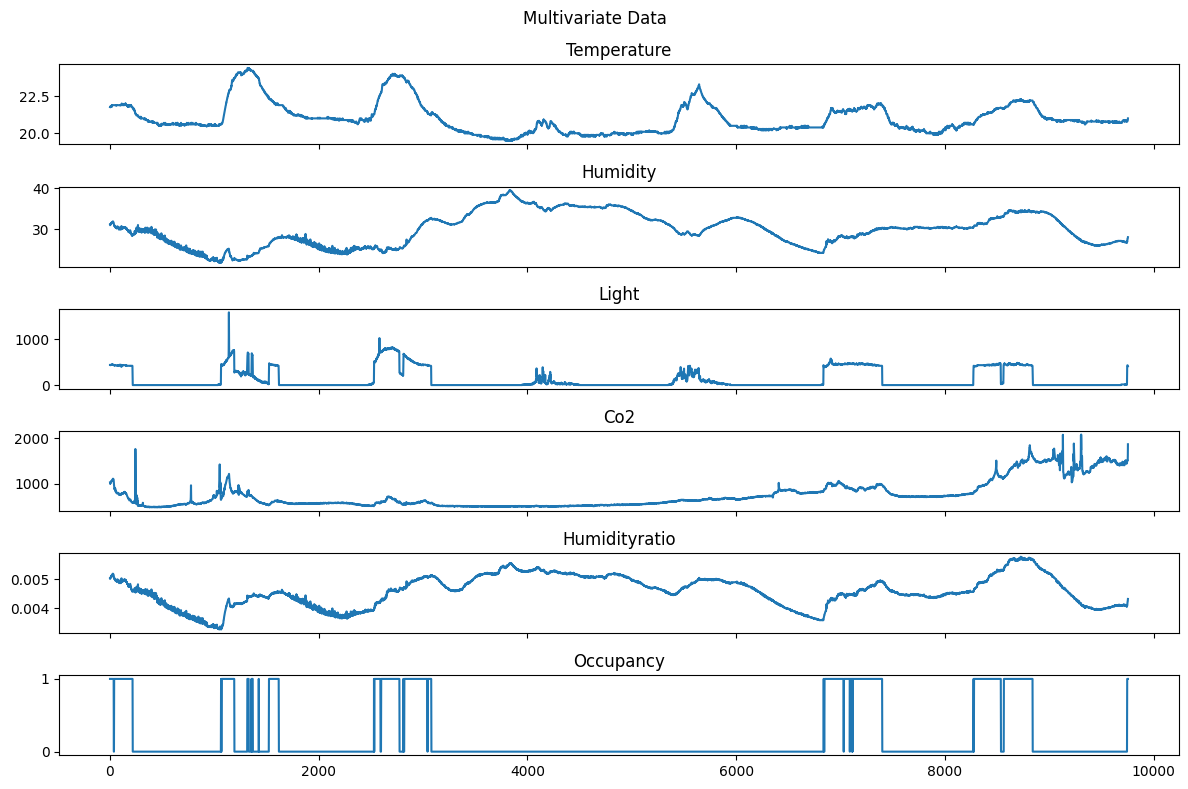

In [23]:
plot_multivariate_data(test_data_df)

### Create Data

In [24]:
train_data_not_scaled = train_data_df.drop('id', axis=1).drop('date', axis=1).to_numpy()
test_data_not_scaled = test_data_df.drop('id', axis=1).drop('date', axis=1).to_numpy()

train_data_not_scaled[:4]

array([[2.31800000e+01, 2.72720000e+01, 4.26000000e+02, 7.21250000e+02,
        4.79298818e-03, 1.00000000e+00],
       [2.31500000e+01, 2.72675000e+01, 4.29500000e+02, 7.14000000e+02,
        4.78344095e-03, 1.00000000e+00],
       [2.31500000e+01, 2.72450000e+01, 4.26000000e+02, 7.13500000e+02,
        4.77946352e-03, 1.00000000e+00],
       [2.31500000e+01, 2.72000000e+01, 4.26000000e+02, 7.08250000e+02,
        4.77150883e-03, 1.00000000e+00]])

In [25]:
train_data_not_scaled[:4, :-1]

array([[2.31800000e+01, 2.72720000e+01, 4.26000000e+02, 7.21250000e+02,
        4.79298818e-03],
       [2.31500000e+01, 2.72675000e+01, 4.29500000e+02, 7.14000000e+02,
        4.78344095e-03],
       [2.31500000e+01, 2.72450000e+01, 4.26000000e+02, 7.13500000e+02,
        4.77946352e-03],
       [2.31500000e+01, 2.72000000e+01, 4.26000000e+02, 7.08250000e+02,
        4.77150883e-03]])

### Preprocess Data

In [26]:
min_max_scaler = MinMaxScaler()

min_max_scaler.fit(train_data_not_scaled[:, :-1])
min_max_scaler.data_max_

array([2.31800000e+01, 3.91175000e+01, 1.54633333e+03, 2.02850000e+03,
       6.47601324e-03])

In [27]:
train_data_no_occupancy = min_max_scaler.transform(train_data_not_scaled[:, :-1])
train_data = np.hstack((train_data_no_occupancy, train_data_not_scaled[:, -1].reshape((-1,1))))

test_data_no_occupancy = min_max_scaler.transform(test_data_not_scaled[:, :-1])
test_data = np.hstack((test_data_no_occupancy, test_data_not_scaled[:, -1].reshape((-1,1))))

train_data.shape, test_data.shape, train_data[:4]

((8143, 6),
 (9752, 6),
 array([[1.        , 0.47053302, 0.27549041, 0.190933  , 0.55731842,
         1.        ],
        [0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723,
         1.        ],
        [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106,
         1.        ],
        [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876,
         1.        ]]))

### Create Datasets

In [28]:
train_dataset = make_windowed_dataset(train_data)
test_dataset = make_windowed_dataset(test_data)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [29]:
train_dataset_no_occ = make_windowed_dataset(train_data, include_occupancy=False)
test_dataset_no_occ = make_windowed_dataset(test_data, include_occupancy=False)

train_dataset_no_occ, test_dataset_no_occ

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#### Verify Datasets Split Correctly

In [30]:
example_data, example_labels = next(iter(train_dataset.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 7, 6), dtype=float64, numpy=
 array([[[1.        , 0.47053302, 0.27549041, 0.190933  , 0.55731842,
          1.        ],
         [0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723,
          1.        ],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106,
          1.        ],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876,
          1.        ],
         [0.98086124, 0.46731478, 0.27549041, 0.1805663 , 0.54785068,
          1.        ],
         [0.98086124, 0.46731478, 0.27096357, 0.17840012, 0.54785068,
          1.        ],
         [0.98086124, 0.46731478, 0.27096357, 0.17881273, 0.54785068,
          1.        ]],
 
        [[0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723,
          1.        ],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106,
          1.        ],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876,
          1.        ],
         [0.980

In [31]:
example_data, example_labels = next(iter(train_dataset_no_occ.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 7, 5), dtype=float64, numpy=
 array([[[1.        , 0.47053302, 0.27549041, 0.190933  , 0.55731842],
         [0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876],
         [0.98086124, 0.46731478, 0.27549041, 0.1805663 , 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17840012, 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17881273, 0.54785068]],
 
        [[0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876],
         [0.98086124, 0.46731478, 0.27549041, 0.1805663 , 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17840012, 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17881273, 0.54785068],
         [0.98086124, 

## Experiments

I am going to perform a handful of experiments to see if I can predict whether a room is occupied or not.

* Experiment-0 (Baseline): Naive Model
* Experiment-1: Feed Forward Model (Windows=7, All Data)
* Experiment-2: Single LSTM (Windows=7, All Data)
* Experiment-3: Single LSTM (Windows=7, No Occupancy Knowledge)
* Experiment-4: Single Bidirectional LSTM (Window=7, No Occupancy Knowledge)
* Experiment-5: Conv1D (Window=7, No Occupancy Knowledge)¶
* Experiment-6: Ensemble (Window=7, No Occupancy Knowledge)

### Constants

In [32]:
INPUT_SHAPE = (7, 6)  # Window of 7 with 6 attributes each window
INPUT_SHAPE_NO_OCCUPANCY = (7, 5)

OUTPUT_SIZE = 1

### Experiment-0: Naive

In [33]:
# Constants
model_0_name = 'model_0_naive'

In [34]:
naive_forecast = test_data[:-1, -1]

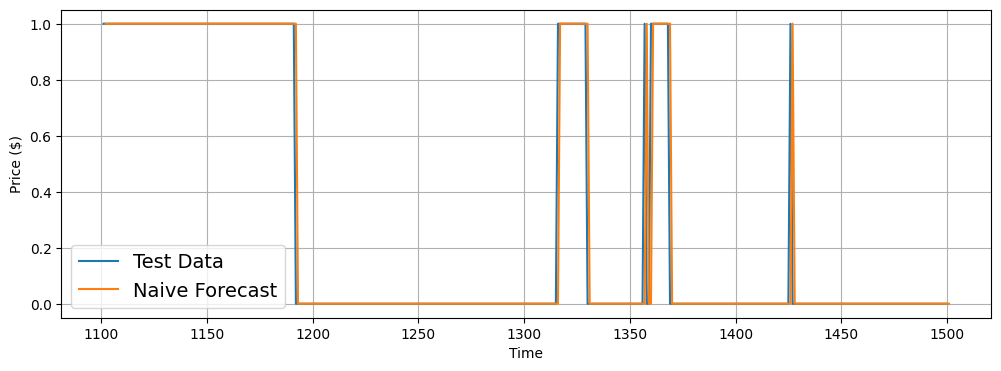

In [35]:
# Data Visualization
plot_occupancy_pred_vs_true(naive_forecast, test_data_df, 1100, 1500, 'Naive Forecast')

In [36]:
model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data[1:, -1], naive_forecast, name=model_0_name)
model_0_results

ClassificationPredictionMetrics(accuracy=0.9950774279561071, precision=0.9950774279561071, recall=0.9950774279561071, f1=0.9950774279561071, name='model_0_naive')

### Experiment-1: Feed Forward Model (Windows=7, All Data)

In [37]:
# Constants
model_1_name = 'model_1_ff'

In [38]:
tf.random.set_seed(RANDOM_SEED)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid'),
], name=model_1_name)

model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_1_history = model_1.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 1s 5ms/step - loss: 0.4622 - accuracy: 0.8279 - val_loss: 0.1914 - val_accuracy: 0.9882
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0840 - accuracy: 0.9882 - val_loss: 0.0416 - val_accuracy: 0.9880
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0438 - accuracy: 0.9878 - val_loss: 0.0398 - val_accuracy: 0.9890
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0394 - accuracy: 0.9891 - val_loss: 0.0366 - val_accuracy: 0.9898
Epoch 5/10
255/255 [==============================] - 1s 2ms/step - loss: 0.0353 - accuracy: 0.9900 - val_loss: 0.0336 - val_accuracy: 0.9913
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0319 - accuracy: 0.9916 - val_loss: 0.0310 - val_accuracy: 0.9924
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0290 - accuracy: 0.9927 - val_loss: 0.0288 - val_accuracy: 0.9934
Epoch 

In [39]:
model_1.summary()

Model: "model_1_ff"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7, 32)             224       
                                                                 
 dense_1 (Dense)             (None, 7, 16)             528       
                                                                 
 dense_2 (Dense)             (None, 7, 8)              136       
                                                                 
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 57        
                                                                 
Total params: 945 (3.69 KB)
Trainable params: 945 (3.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model_1_preds = make_predictions(model_1, test_dataset)
model_1_preds[:5]

305/305 [==============================] - 1s 1ms/step


<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>

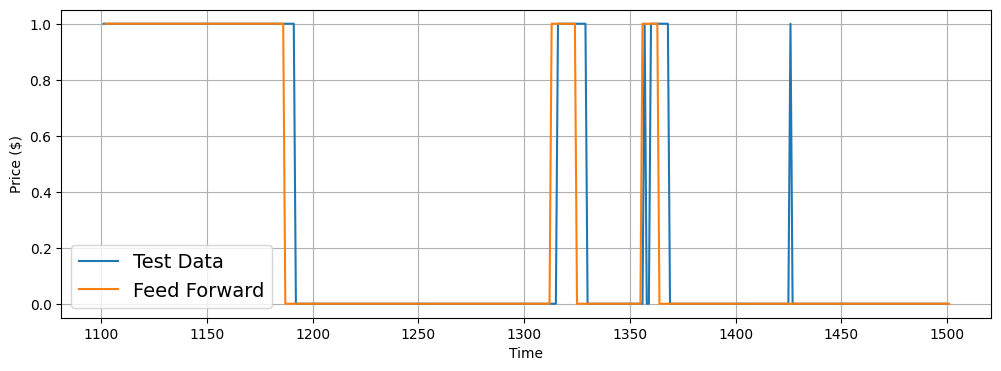

In [41]:
# Data Visualization
plot_occupancy_pred_vs_true(model_1_preds, test_data_df, 1100, 1500, 'Feed Forward')

In [42]:
model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_1)
model_1_results

ClassificationPredictionMetrics(accuracy=0.9946639302206259, precision=0.9946569057535317, recall=0.9946639302206259, f1=0.994658144203442, name='model_1_ff')

### Experiment-2: Single LSTM (Window=7, All Data)

In [43]:
# constants
model_2_name = 'model_2_lstm_w7'

In [44]:
tf.random.set_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)

model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_2_history = model_2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 2s 4ms/step - loss: 0.4376 - accuracy: 0.8477 - val_loss: 0.1074 - val_accuracy: 0.9867
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0851 - accuracy: 0.9848 - val_loss: 0.0671 - val_accuracy: 0.9857
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0668 - accuracy: 0.9844 - val_loss: 0.0594 - val_accuracy: 0.9867
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0600 - accuracy: 0.9849 - val_loss: 0.0560 - val_accuracy: 0.9868
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0571 - accuracy: 0.9845 - val_loss: 0.0538 - val_accuracy: 0.9870
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0544 - accuracy: 0.9850 - val_loss: 0.0513 - val_accuracy: 0.9872
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0514 - accuracy: 0.9853 - val_loss: 0.0488 - val_accuracy: 0.9878
Epoch 

In [45]:
model_2.summary()

Model: "model_2_lstm_w7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1489 (5.82 KB)
Trainable params: 1489 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


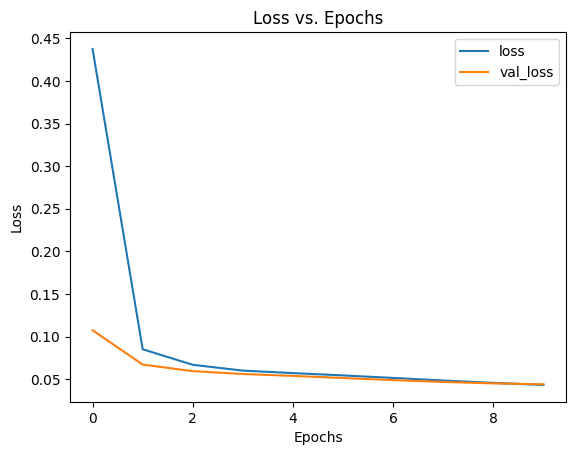

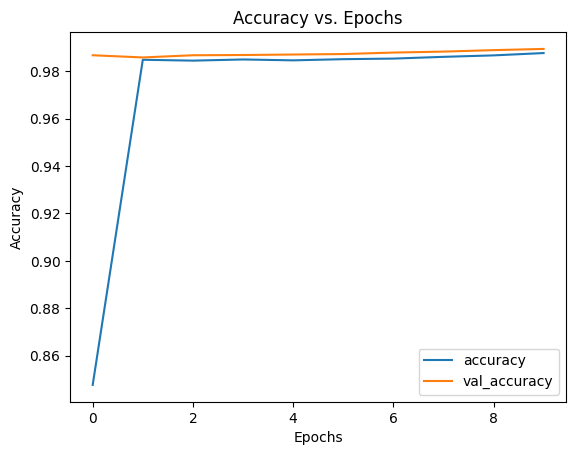

In [46]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_2_history, 'accuracy')

In [47]:
model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_2)
model_2_results

ClassificationPredictionMetrics(accuracy=0.9893278604412519, precision=0.9893552671956, recall=0.9893278604412519, f1=0.98933933386111, name='model_2_lstm_w7')

### Experiment-3: Single LSTM (Window=7, No Occupancy Knowledge)

In [48]:
# Constants
model_3_name = 'model_3_lstm_w7_no_occ'

In [49]:
tf.random.set_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_NO_OCCUPANCY)
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_3_history = model_3.fit(
    train_dataset_no_occ,
    validation_data=test_dataset_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 2s 3ms/step - loss: 0.6472 - accuracy: 0.7879 - val_loss: 0.4214 - val_accuracy: 0.8024
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.2804 - accuracy: 0.9149 - val_loss: 0.2681 - val_accuracy: 0.8630
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1602 - accuracy: 0.9593 - val_loss: 0.2858 - val_accuracy: 0.8780
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1334 - accuracy: 0.9634 - val_loss: 0.2714 - val_accuracy: 0.9228
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1185 - accuracy: 0.9687 - val_loss: 0.2177 - val_accuracy: 0.9345
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1058 - accuracy: 0.9700 - val_loss: 0.1704 - val_accuracy: 0.9391
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0946 - accuracy: 0.9723 - val_loss: 0.1398 - val_accuracy: 0.9491
Epoch 

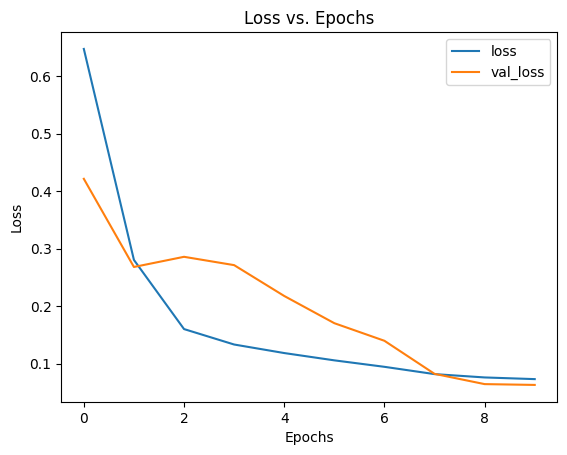

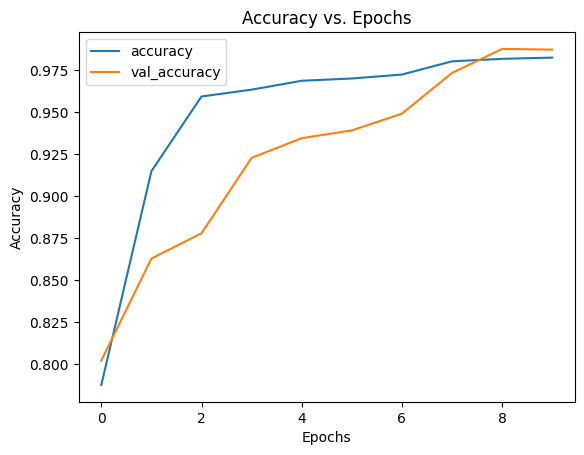

In [50]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_3_history, 'accuracy')

In [51]:
model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_no_occ, model_3)
model_3_results

ClassificationPredictionMetrics(accuracy=0.987172909184197, precision=0.9872815260740597, recall=0.987172909184197, f1=0.9872105497986233, name='model_3_lstm_w7_no_occ')

### Experiment-4: Single Bidirectional LSTM (Window=7, No Occupancy Knowledge)

In [52]:
# Constants
model_4_name = 'model_4_bidirect_lstm_w7_no_occ'

In [53]:
tf.random.set_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_NO_OCCUPANCY)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_4_history = model_4.fit(
    train_dataset_no_occ,
    validation_data=test_dataset_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 3s 5ms/step - loss: 0.4885 - accuracy: 0.8033 - val_loss: 0.3056 - val_accuracy: 0.8579
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1564 - accuracy: 0.9540 - val_loss: 0.3356 - val_accuracy: 0.8624
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1180 - accuracy: 0.9660 - val_loss: 0.2389 - val_accuracy: 0.9263
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0985 - accuracy: 0.9707 - val_loss: 0.1754 - val_accuracy: 0.9408
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0805 - accuracy: 0.9760 - val_loss: 0.1131 - val_accuracy: 0.9573
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0680 - accuracy: 0.9845 - val_loss: 0.0744 - val_accuracy: 0.9684
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0638 - accuracy: 0.9854 - val_loss: 0.0459 - val_accuracy: 0.9897
Epoch 

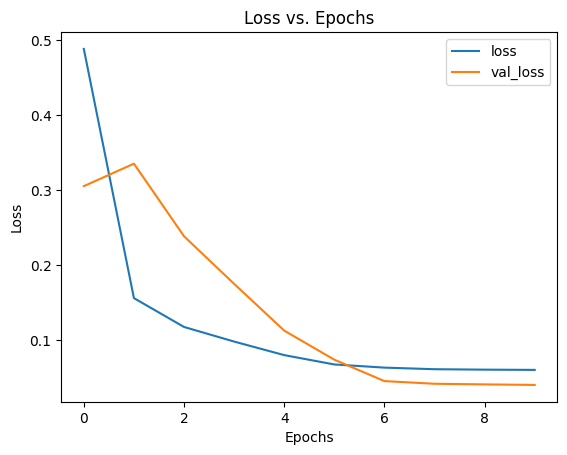

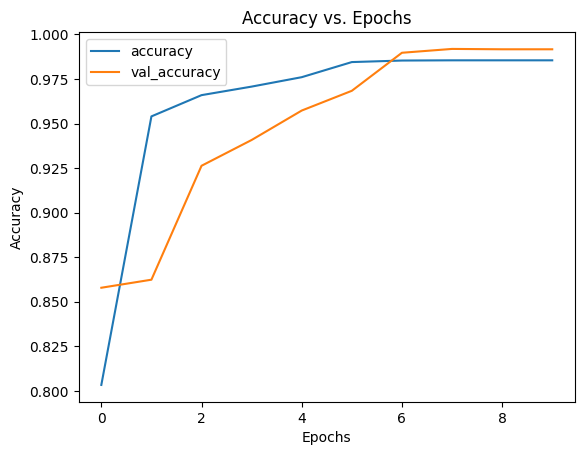

In [54]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_4_history, 'accuracy')

In [55]:
model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_no_occ, model_4)
model_4_results

ClassificationPredictionMetrics(accuracy=0.9916880451513597, precision=0.9916865801615738, recall=0.9916880451513597, f1=0.9916872970239305, name='model_3_lstm_w7_no_occ')

### Experiment-5: Conv1D (Window=7, No Occupancy Knowledge)

In [56]:
# Constants
model_5_name = 'model_5_conv_w7_no_occ'

In [57]:
tf.random.set_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_NO_OCCUPANCY)
x = tf.keras.layers.Conv1D(32, 3)(inputs)
x = tf.keras.layers.Conv1D(16, 3)(inputs)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_5 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_5_history = model_5.fit(
    train_dataset_no_occ,
    validation_data=test_dataset_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 1s 3ms/step - loss: 0.6181 - accuracy: 0.7883 - val_loss: 0.4658 - val_accuracy: 0.7908
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.4468 - accuracy: 0.8510 - val_loss: 0.3856 - val_accuracy: 0.8535
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.3069 - accuracy: 0.9381 - val_loss: 0.3044 - val_accuracy: 0.8855
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.2077 - accuracy: 0.9604 - val_loss: 0.2528 - val_accuracy: 0.8876
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1550 - accuracy: 0.9646 - val_loss: 0.2249 - val_accuracy: 0.8951
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1283 - accuracy: 0.9664 - val_loss: 0.2049 - val_accuracy: 0.9054
Epoch 7/10
255/255 [==============================] - 1s 2ms/step - loss: 0.1131 - accuracy: 0.9687 - val_loss: 0.1873 - val_accuracy: 0.9126
Epoch 

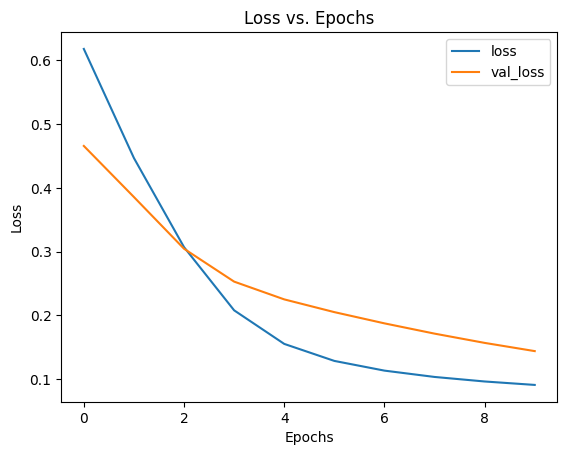

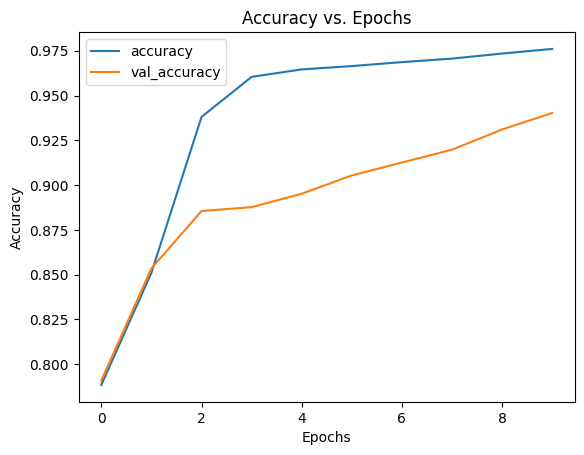

In [58]:
ml_toolbox.analysis.history.plot_history(model_5_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_5_history, 'accuracy')

In [59]:
model_5_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_no_occ, model_5)
model_5_results

ClassificationPredictionMetrics(accuracy=0.9402770651616214, precision=0.9402278329201433, recall=0.9402770651616214, f1=0.9379323478115928, name='model_3_lstm_w7_no_occ')

### Experiment-6: Ensemble (Window=7, No Occupancy Knowledge)¶

In [60]:
# Constants
model_6_name = 'model_6_ensemble'

In [61]:
# Build, Compile, and Fit Models
ensemble_models = get_ensemble_models(input_shape=INPUT_SHAPE_NO_OCCUPANCY,
                                      train_data=train_dataset_no_occ,
                                      test_data=test_dataset_no_occ,
                                      num_iter=5,
                                      num_epochs=10)

Optimizing model by reducing: for 10, model number: 0
Optimizing model by reducing: for 10, model number: 1
Optimizing model by reducing: for 10, model number: 2
Optimizing model by reducing: for 10, model number: 3
Optimizing model by reducing: for 10, model number: 4


In [62]:
model_6_mean_results, model_6_median_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_models(
    test_dataset_no_occ, ensemble_models, model_6_name)

model_6_mean_results, model_6_median_results

(ClassificationPredictionMetrics(accuracy=0.975782452539764, precision=0.9759642911435757, recall=0.975782452539764, f1=0.9753738935550764, name='model_6_ensemble_mean'),
 ClassificationPredictionMetrics(accuracy=0.9789635710620831, precision=0.9789434213057235, recall=0.9789635710620831, f1=0.9787285146964673, name='model_6_ensemble_median'))

## Analysis

After running the 7 experiments, I want to analyze the performance and prediction metrics of each model to identify how well each model performed and analyze how certain data can affect predictions.

In [63]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_5_results,
    model_6_mean_results,
    model_6_median_results,
]

all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

,accuracy,precision,recall,f1
model_0_naive,0.995077,0.995077,0.995077,0.995077
model_1_ff,0.994664,0.994657,0.994664,0.994658
model_2_lstm_w7,0.989328,0.989355,0.989328,0.989339
model_3_lstm_w7_no_occ,0.940277,0.940228,0.940277,0.937932
model_6_ensemble_mean,0.975782,0.975964,0.975782,0.975374
model_6_ensemble_median,0.978964,0.978943,0.978964,0.978729


<Axes: >

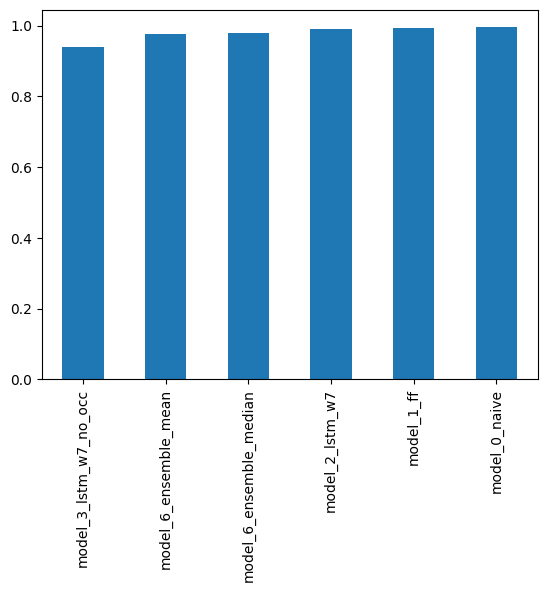

In [64]:
all_results_df['accuracy'].sort_values().plot(kind='bar')